In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import scipy.sparse.linalg

In [2]:
def sqrtinvdiag(M):
    """Inverts and square-roots a positive diagonal matrix.
    Args:
        M (csc matrix): matrix to invert
    Returns:
        scipy sparse matrix of inverted square-root of diagonal
    """

    d = M.diagonal()
    dd = [1 / max(np.sqrt(x), 1 / 999999999) for x in d]

    return sp.dia_matrix((dd, [0]), shape=(len(d), len(d))).tocsc()

[1 3 2 0 4 7 8 6 5]
[0.10025431 0.15874452 0.10815721 0.11630745 0.07455014 0.0226713
 0.03118985 0.04406377 0.03325026]


/home/ubuntu/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


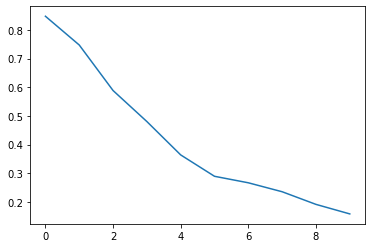

In [5]:
adj = sp.load_npz('./adj.npz')
A = adj.tocsc()
D_out = sp.diags(A.transpose().sum(
    axis=0).tolist(), [0]).tocsc()
D_in = sp.diags(A.sum(axis=0).tolist(), [0]).tocsc()
Dbar = (D_in + D_out)
d = sqrtinvdiag(Dbar)
normA = d * A * d
size = A.shape[0]
H = (A-A.transpose()) * 1j
H_abs = np.abs(H)
D_abs_inv = sp.diags(1/np.array(H_abs.sum(1))[:, 0])
D_abs_inv.data[np.isinf(D_abs_inv.data)] = 0.0
H_rw = D_abs_inv.dot(H)
_, s, _ = sp.linalg.svds(H_rw, 10)
eigens = s[list(np.arange(9,-1,-1))]
eigengaps = eigens[:-1] - eigens[1:]
print(np.argsort(-eigengaps))
print(eigengaps)
plt.plot(eigens)
plt.show()
# choose K = 3

In [6]:
adj

<21x21 sparse matrix of type '<class 'numpy.int64'>'
	with 193 stored elements in Compressed Sparse Row format>

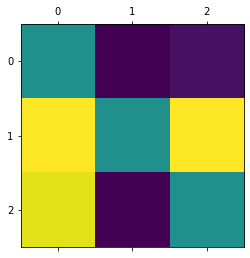

3

In [7]:
import sklearn.cluster as sl
import torch
import matplotlib.pyplot as plt

num_clusters = 3
u, s, vt = sp.linalg.svds(H_rw, num_clusters)
features_SVD = np.concatenate((np.real(u), np.imag(u)), axis=1)
labels = sl.KMeans(n_clusters=num_clusters).fit_predict(features_SVD)
A = torch.FloatTensor(A.toarray())
P = torch.zeros(labels.shape[0], num_clusters).to(A.device)
for k in range(num_clusters):
    P[labels == k, k] = 1
flow_mat = np.ones([num_clusters, num_clusters])*0.5
for k in range(num_clusters-1):
    for l in range(k+1, num_clusters):
        w_kl = torch.matmul(P[:, k], torch.matmul(A, P[:, l])).item()
        w_lk = torch.matmul(P[:, l], torch.matmul(A, P[:, k])).item()
        if (w_kl + w_lk) > 0:
            flow_mat[k, l] = w_kl/(w_kl + w_lk)
            flow_mat[l, k] = w_lk/(w_kl + w_lk)
plt.matshow(flow_mat)
plt.show()
np.sum(flow_mat>0.9)